In [1]:
import numpy as np
import pandas as pd
import os
import glob
from analysis_helper import *
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

iter_max=10
task_col='pcba-aid624173'
cluster_col='BT_0.4 ID'

run_threshold=5
hs_params, benchmark_params, custom_params = 70, 4, 4
hs_job_count = hs_params*3*10
benchmark_job_count = benchmark_params*3*10 
custom_job_count = custom_params*3*10

hs_dir = glob.glob('../../../aldd_results/params_results_exp_1_latest/*/*/*/*/')
custom_dir = glob.glob('../../../aldd_results/params_results_custom_cbws/*/*/*/*/')
benchmark_dir = glob.glob('../../../aldd_results/params_results_benchmarks/*/*/*/*/')

In [2]:
all_96_hs, all_384_hs, all_1536_hs, all_df_hs, successful_jobs, failed_jobs = get_results(hs_dir, iter_max, task_col, cluster_col, run_threshold)

print('----------------------------------------------------------------------------')
print('HS Jobs:')
print('Total jobs: {}'.format(hs_job_count))
print('Failed jobs: {}'.format(len(failed_jobs)))
print('Successful jobs: {}'.format(len(successful_jobs)))

hs_unique = np.unique(["_".join(x.split('_')[0:2]) for x in successful_jobs])
print('Total HS: {}'.format(hs_params))
print('Successful HS: {}'.format(len(hs_unique)))

1155/1156
----------------------------------------------------------------------------
HS Jobs:
Total jobs: 2100
Failed jobs: 354
Successful jobs: 802
Total HS: 70
Successful HS: 62


In [3]:
all_96_bm, all_384_bm, all_1536_bm, all_df_bm, successful_jobs, failed_jobs = get_results(benchmark_dir, iter_max, task_col, cluster_col, run_threshold)

print('----------------------------------------------------------------------------')
print('Benchmark Jobs:')
print('Total jobs: {}'.format(benchmark_job_count))
print('Failed jobs: {}'.format(len(failed_jobs)))
print('Successful jobs: {}'.format(len(successful_jobs)))

hs_unique = np.unique(["_".join(x.split('_')[0:2]) for x in successful_jobs])
print('Total HS: {}'.format(benchmark_params))
print('Successful HS: {}'.format(len(hs_unique)))

43/44
----------------------------------------------------------------------------
Benchmark Jobs:
Total jobs: 120
Failed jobs: 0
Successful jobs: 44
Total HS: 4
Successful HS: 4


In [4]:
all_96_cs, all_384_cs, all_1536_cs, all_df_cs, successful_jobs, failed_jobs = get_results(custom_dir, iter_max, task_col, cluster_col, run_threshold)

print('----------------------------------------------------------------------------')
print('Custom Jobs:')
print('Total jobs: {}'.format(custom_job_count))
print('Failed jobs: {}'.format(len(failed_jobs)))
print('Successful jobs: {}'.format(len(successful_jobs)))

hs_unique = np.unique(["_".join(x.split('_')[0:3]) for x in successful_jobs])
print('Total HS: {}'.format(custom_params))
print('Successful HS: {}'.format(len(hs_unique)))

68/69
----------------------------------------------------------------------------
Custom Jobs:
Total jobs: 120
Failed jobs: 31
Successful jobs: 38
Total HS: 4
Successful HS: 2


---
# Top models for batch_size=96

In [5]:
des_cols = ['exploitation_hits_mean', 'exploration_hits_mean', 'total_hits_mean', 'total_hits_std',
            'total_unique_hits_mean', 'run_counts', 'hs_group']
top_96_hs = get_top_summary(all_96_hs)
top_96_bm = get_top_summary(all_96_bm)
top_96_cs = get_top_summary(all_96_cs)

---
# Focus on batch_size=96

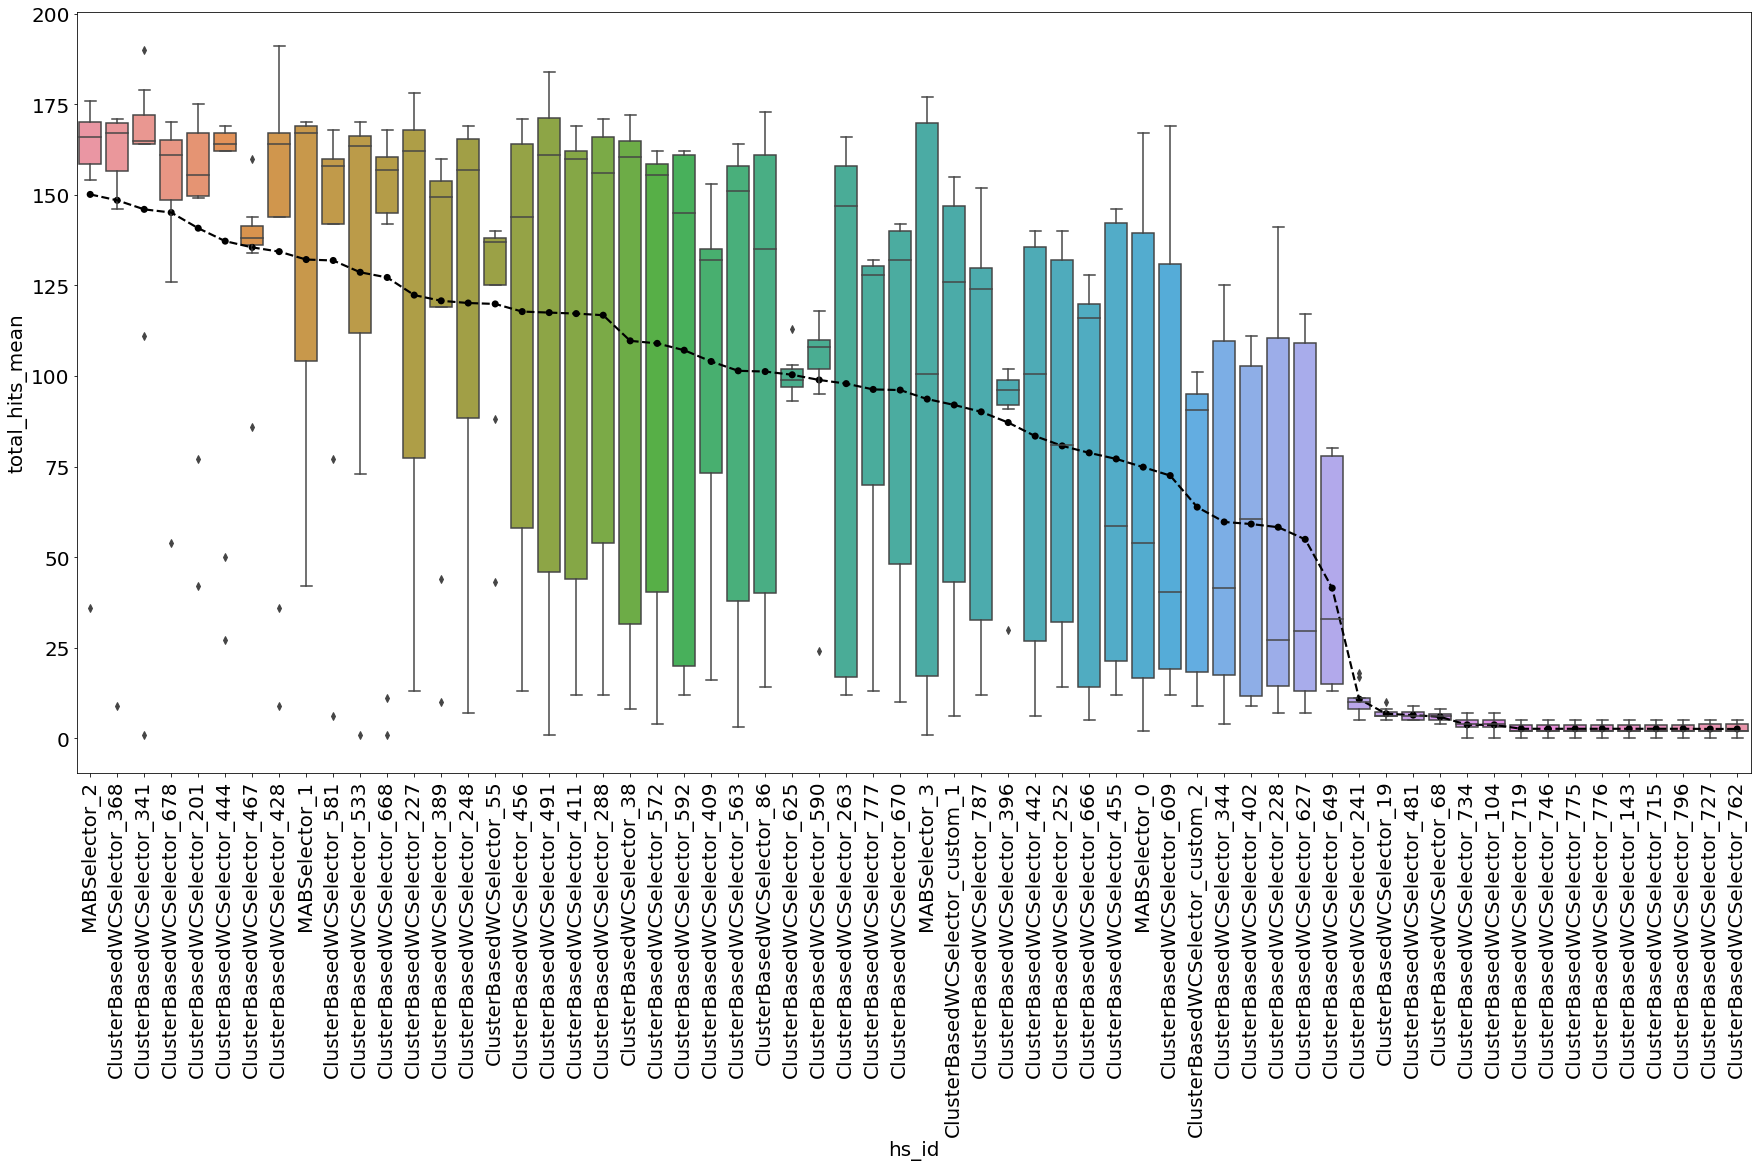

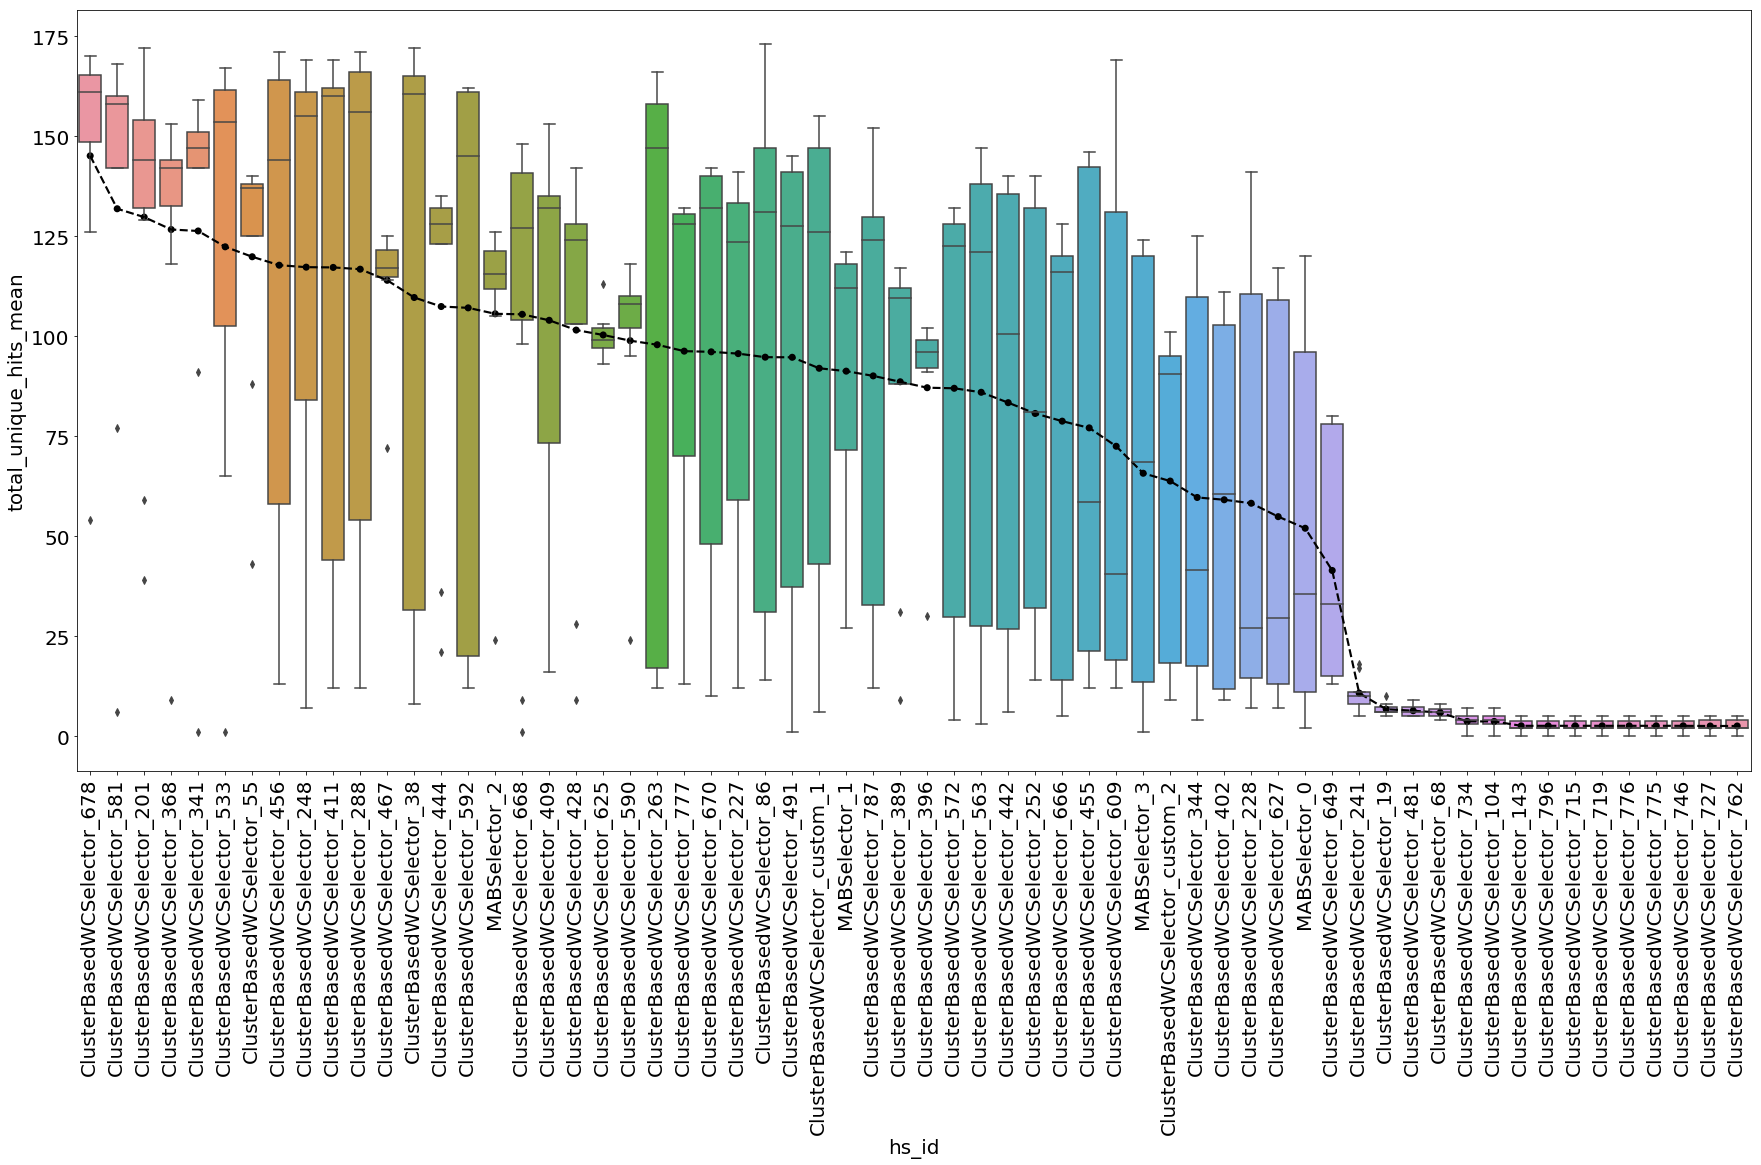

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
from stat_analysis import *
%autoreload 2

all_96 = pd.concat([all_96_cs, all_96_bm, all_96_hs])
top_96_all = pd.concat([top_96_cs, top_96_bm, top_96_hs])
plot_hs_boxplots(all_96, top_96_all, metric_col_box='total_hits', metric_col_point='total_hits_mean')
plot_hs_boxplots(all_96, top_96_all, metric_col_box='total_unique_hits', metric_col_point='total_unique_hits_mean')

In [18]:
from stat_analysis import *
%autoreload 2

alpha=0.05
hs_ids = all_96['hs_id'].unique()

hits_dtk = get_dtk_df(all_96, metric_col='total_hits', alpha=alpha)
unique_hits_dtk = get_dtk_df(all_96, metric_col='total_unique_hits', alpha=alpha)

hits_wins = get_dtk_win_sum(hits_dtk, hs_ids)
uhits_wins = get_dtk_win_sum(unique_hits_dtk, hs_ids)

summed_wins = (hits_wins+uhits_wins).sort_values(ascending=False)
top_15_dtk = summed_wins.index[:15].tolist()
summed_wins[:15]

ClusterBasedWCSelector_625    32.0
ClusterBasedWCSelector_467    32.0
ClusterBasedWCSelector_678    32.0
ClusterBasedWCSelector_368    31.0
ClusterBasedWCSelector_55     30.0
ClusterBasedWCSelector_581    30.0
ClusterBasedWCSelector_590    30.0
ClusterBasedWCSelector_201    30.0
ClusterBasedWCSelector_396    30.0
ClusterBasedWCSelector_341    30.0
MABSelector_2                 30.0
ClusterBasedWCSelector_444    29.0
ClusterBasedWCSelector_428    28.0
ClusterBasedWCSelector_668    25.0
ClusterBasedWCSelector_409    24.0
dtype: float64

---
Looking at config of these top performers, we can see the reason for why some don't do exploitation. See overleaf document for full explanation, but the following is the summary:

To guarantee that some exploitation takes place every iteration (although this may not be the best strategy), then set \textbf{exploitation_use_quantile_for_activity} and \textbf{exploitation_use_quantile_for_weight} to true. 

Conceivably, these top performers may perform exploitation in later iterations when the model matures and the activity predictions are pushed to the edges.

In [79]:
import json 

temp_df = all_96.loc[top_15_dtk].drop_duplicates('hs_id')

config_df = pd.concat([pd.read_csv(x) for x in temp_df['config_file']]).reset_index(drop=True)
config_df['class'] = temp_df['hs_id'].reset_index(drop=True)
config_df.index = config_df['class']
a = pd.concat([top_96_all.loc[top_15_dtk][des_cols], config_df], axis=1)
a = a[['exploitation_hits_mean', 
       'exploitation_alpha', 
       'exploitation_activity_threshold', 
       'exploitation_weight_threshold',
       'exploitation_use_quantile_for_activity',
       'exploitation_use_quantile_for_weight']].sort_values('exploitation_hits_mean')
a

C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


,exploitation_hits_mean,exploitation_alpha,exploitation_activity_threshold,exploitation_weight_threshold,exploitation_use_quantile_for_activity,exploitation_use_quantile_for_weight
ClusterBasedWCSelector_678,0.000000,0.50,0.25,0.50,True,False
ClusterBasedWCSelector_55,0.000000,0.75,1.00,1.00,False,True
ClusterBasedWCSelector_590,0.000000,0.25,0.50,0.50,False,True
ClusterBasedWCSelector_396,0.000000,0.25,0.25,0.50,True,False
ClusterBasedWCSelector_428,0.000000,0.50,0.50,0.50,True,False
ClusterBasedWCSelector_409,0.000000,0.25,0.75,0.00,False,False
ClusterBasedWCSelector_625,0.111111,0.50,0.25,0.00,False,False
ClusterBasedWCSelector_201,0.400000,1.00,0.75,0.75,False,True
ClusterBasedWCSelector_444,11.888889,1.00,0.75,0.75,False,False
ClusterBasedWCSelector_341,17.444444,1.00,0.75,0.75,True,False


---
# Top models for batch_size=384

In [80]:
des_cols = ['exploitation_hits_mean', 'exploration_hits_mean', 'total_hits_mean', 'total_hits_std',
            'total_unique_hits_mean', 'run_counts', 'hs_group']
top_384_hs = get_top_summary(all_384_hs)
top_384_hs[des_cols]

,exploitation_hits_mean,exploration_hits_mean,total_hits_mean,total_hits_std,total_unique_hits_mean,run_counts,hs_group
hs_id,,,,,,,
ClusterBasedWCSelector_411,0.000000,218.571429,218.571429,18.410659,218.571429,7,top_384
ClusterBasedWCSelector_444,13.375000,204.875000,218.250000,22.473794,167.875000,8,top_1536
ClusterBasedWCSelector_341,17.833333,200.166667,218.000000,18.406521,193.333333,6,top_96
ClusterBasedWCSelector_227,0.000000,214.333333,214.333333,11.779219,175.777778,9,top_1536
ClusterBasedWCSelector_609,0.000000,213.857143,213.857143,21.114202,213.857143,7,top_1536
ClusterBasedWCSelector_86,0.000000,211.000000,211.000000,18.894444,145.888889,9,top_1536
ClusterBasedWCSelector_533,3.250000,202.375000,205.625000,15.546589,145.625000,8,top_1536
ClusterBasedWCSelector_563,9.700000,194.900000,204.600000,14.758802,150.800000,10,top_1536
ClusterBasedWCSelector_572,20.571429,181.571429,202.142857,19.368605,173.000000,7,top_1536


In [12]:
top_384_bm = get_top_summary(all_384_bm)
top_384_bm[des_cols]

,exploitation_hits_mean,exploration_hits_mean,total_hits_mean,total_hits_std,total_unique_hits_mean,run_counts,hs_group
hs_id,,,,,,,


In [13]:
top_384_cs = get_top_summary(all_384_cs)
top_384_cs[des_cols]

,exploitation_hits_mean,exploration_hits_mean,total_hits_mean,total_hits_std,total_unique_hits_mean,run_counts,hs_group
hs_id,,,,,,,
ClusterBasedWCSelector_custom_1,100.3,64.200000,164.500000,51.895729,164.500000,10,custom_cbws
ClusterBasedWCSelector_custom_2,0.0,138.444444,138.444444,21.083827,138.444444,9,custom_cbws


In [14]:
pd.concat([top_384_cs, top_384_bm, top_384_hs.head(10)]).sort_values('total_hits_mean',ascending=False)[des_cols]

C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,exploitation_hits_mean,exploration_hits_mean,total_hits_mean,total_hits_std,total_unique_hits_mean,run_counts,hs_group
hs_id,,,,,,,
ClusterBasedWCSelector_411,0.000000,218.571429,218.571429,18.410659,218.571429,7.0,top_384
ClusterBasedWCSelector_444,13.375000,204.875000,218.250000,22.473794,167.875000,8.0,top_1536
ClusterBasedWCSelector_341,17.833333,200.166667,218.000000,18.406521,193.333333,6.0,top_96
ClusterBasedWCSelector_227,0.000000,214.333333,214.333333,11.779219,175.777778,9.0,top_1536
ClusterBasedWCSelector_609,0.000000,213.857143,213.857143,21.114202,213.857143,7.0,top_1536
ClusterBasedWCSelector_86,0.000000,211.000000,211.000000,18.894444,145.888889,9.0,top_1536
ClusterBasedWCSelector_533,3.250000,202.375000,205.625000,15.546589,145.625000,8.0,top_1536
ClusterBasedWCSelector_563,9.700000,194.900000,204.600000,14.758802,150.800000,10.0,top_1536
ClusterBasedWCSelector_572,20.571429,181.571429,202.142857,19.368605,173.000000,7.0,top_1536


---
# Top models for batch_size=1536

In [15]:
des_cols = ['exploitation_hits_mean', 'exploration_hits_mean', 'total_hits_mean', 'total_hits_std',
            'total_unique_hits_mean', 'run_counts', 'hs_group']
top_1536_hs = get_top_summary(all_1536_hs)
top_1536_hs[des_cols]

,exploitation_hits_mean,exploration_hits_mean,total_hits_mean,total_hits_std,total_unique_hits_mean,run_counts,hs_group
hs_id,,,,,,,
ClusterBasedWCSelector_104,0.0,49.1,49.1,6.332456,49.1,10,worst_96
ClusterBasedWCSelector_734,0.0,48.6,48.6,5.719363,48.6,10,middle_1536


In [16]:
top_1536_bm = get_top_summary(all_1536_bm)
top_1536_bm[des_cols]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
top_1536_cs = get_top_summary(all_1536_cs)
top_1536_cs[des_cols]